# LSUN Bedrooms

In [6]:
from miniai.imports import *
from miniai.diffusion import *

from glob import glob
from fastprogress import progress_bar
from diffusers import AutoencoderKL, UNet2DConditionModel
import shutil

In [2]:
import timm

In [3]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [4]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'bedroom'

In [7]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/bedroom.tgz', 'data')

In [8]:
bs = 64

In [9]:
def to_img(f): return read_image(f, mode=ImageReadMode.RGB)/255

In [10]:
class ImagesDS:
    def __init__(self, spec):
        self.path = Path(path)
        self.files = glob(str(spec), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i): return to_img(self.files[i])[:, :256,:256]

In [11]:
ds = ImagesDS(path/f'**/*.jpg')

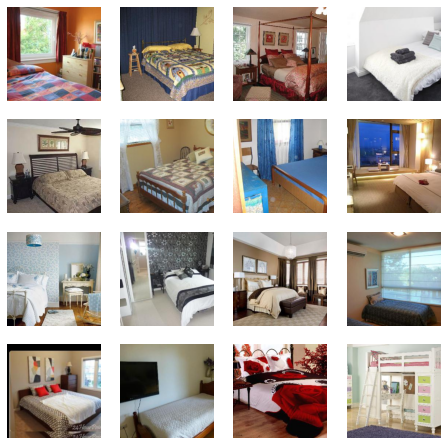

In [12]:
dl = DataLoader(ds, batch_size=bs, num_workers=fc.defaults.cpus)
xb = next(iter(dl))
show_images(xb[:16], imsize=2)

In [13]:
xb[:16].shape

torch.Size([16, 3, 256, 256])

In [14]:
16*3*256*256

3145728

## VAE

In [15]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [16]:
xe = vae.encode(xb.cuda())

In [17]:
xs = xe.latent_dist.mean[:16]
xs.shape

torch.Size([16, 4, 32, 32])

In [18]:
(16*3*256*256)/(16*4*32*32)

48.0

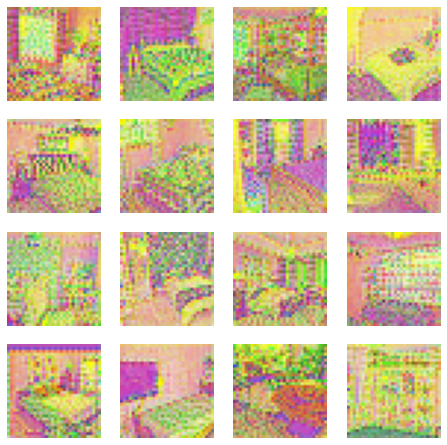

In [19]:
show_images(((xs[:16,:3])/4).sigmoid(), imsize=2)

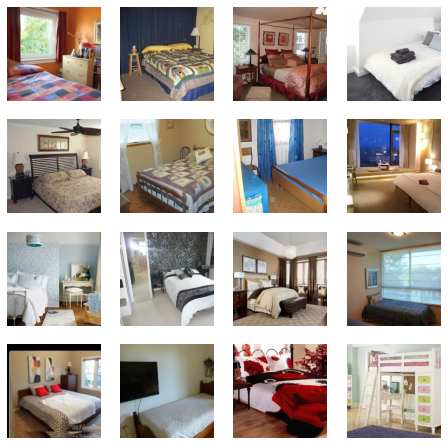

In [20]:
xd = to_cpu(vae.decode(xs))
show_images(xd['sample'].clamp(0,1), imsize=2)

In [21]:
mmpath = Path('data/bedroom/data.npmm')

In [22]:
len(ds)

303125

In [23]:
mmshape = (303125,4,32,32)

In [24]:
if not mmpath.exists():
    a = np.memmap(mmpath, np.float32, mode='w+', shape=mmshape)
    i = 0
    for b in progress_bar(dl):
        n = len(b)
        a[i:i+n] = to_cpu(vae.encode(b.cuda()).latent_dist.mean).numpy()
        i += n
    a.flush()
    del(a)

In [25]:
lats = np.memmap(mmpath, dtype=np.float32, mode='r', shape=mmshape)

In [26]:
b = torch.tensor(lats[:16])

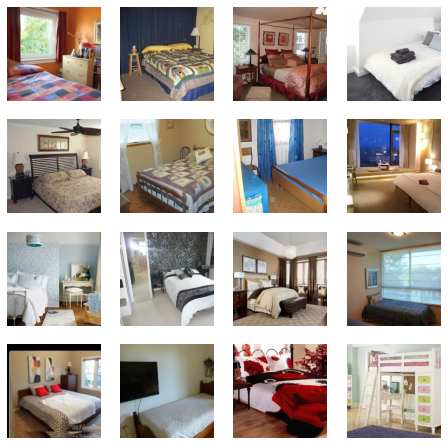

In [27]:
xd = to_cpu(vae.decode(b.cuda()))
show_images(xd['sample'].clamp(0,1), imsize=2)

## Noisify

In [28]:
def collate_ddpm(b): return noisify(default_collate(b)*0.2)

In [29]:
n = len(lats)

In [30]:
tds = lats[:n//10*9 ]
vds = lats[ n//10*9:]

In [31]:
bs = 128

In [32]:
dls = DataLoaders(*get_dls(tds, vds, bs=bs, num_workers=fc.defaults.cpus, collate_fn=collate_ddpm))

In [33]:
import warnings

In [34]:
warnings.simplefilter('ignore', UserWarning)

In [35]:
(xt,t),eps = b = next(iter(dls.train))

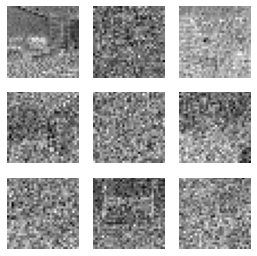

In [36]:
show_images(xt[:9,0], imsize=1.5)

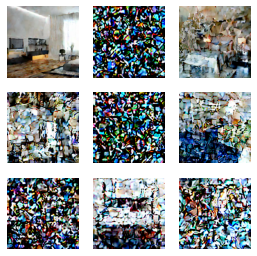

In [37]:
xte = vae.decode(xt[:9].cuda()*5)['sample']
show_images(xte.clamp(0,1), imsize=1.5)

## Train

In [38]:
def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [39]:
lr = 3e-3
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=4, out_channels=4, nfs=(128, 256, 512, 768), num_layers=2,
                     attn_start=1, attn_chans=16)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.296,0,train
0.274,0,eval
0.270,1,train
0.267,1,eval
0.263,2,train
0.262,2,eval
0.260,3,train
0.261,3,eval
0.258,4,train
0.256,4,eval


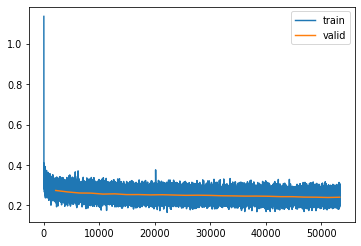

In [40]:
learn.fit(epochs)

In [41]:
torch.save(learn.model.state_dict(), 'models/lsun_diffusion-latents.pkl')

## Sampling

In [42]:
sz = (16,4,32,32)

In [43]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=False)

In [44]:
s = preds[-1]*5

In [45]:
with torch.no_grad(): pd = to_cpu(vae.decode(s.cuda()))

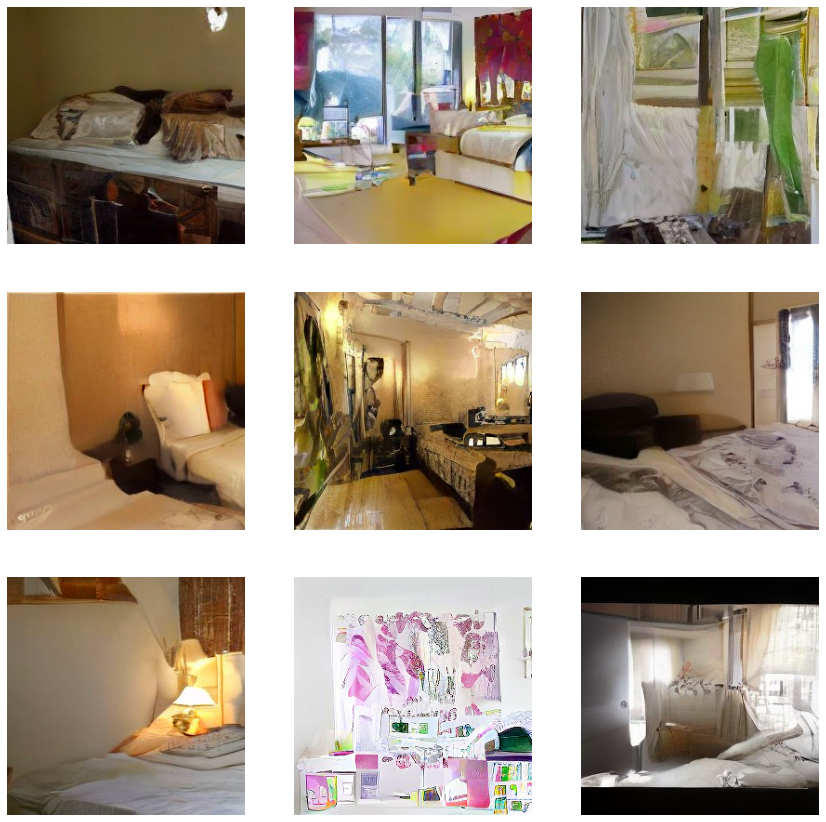

In [46]:
show_images(pd['sample'][:9].clamp(0,1), imsize=5)